# Chapter 2, gradient descent

## 1. The Input Data: A Grid of Pixels

Our goal is to classify handwritten digits. The data for this task consists of images rendered on a **28x28 pixel grid**. Each pixel has a grayscale value, typically ranging from **0 (black)** to **1 (white)**.

These raw pixel values become the initial input for our network. Since there are $28 \times 28 = 784$ pixels, they will determine the activation of **784 neurons** in the network's first layer.

Let's load a sample digit from the popular MNIST dataset to see what one looks like.

In [7]:
def get_mnist():
    # The code to download the mnist data original came from
    # https://cntk.ai/pythondocs/CNTK_103A_MNIST_DataLoader.html
    
    import gzip
    import numpy as np
    import os
    import struct

    from urllib.request import urlretrieve 

    def load_data(src, num_samples):
        print("Downloading " + src)
        gzfname, h = urlretrieve(src, "./delete.me")
        print("Done.")
        try:
            with gzip.open(gzfname) as gz:
                n = struct.unpack("I", gz.read(4))
                # Read magic number.
                if n[0] != 0x3080000:
                    raise Exception("Invalid file: unexpected magic number.")
                # Read number of entries.
                n = struct.unpack(">I", gz.read(4))[0]
                if n != num_samples:
                    raise Exception(
                        "Invalid file: expected {0} entries.".format(num_samples)
                    )
                crow = struct.unpack(">I", gz.read(4))[0]
                ccol = struct.unpack(">I", gz.read(4))[0]
                if crow != 28 or ccol != 28:
                    raise Exception(
                        "Invalid file: expected 28 rows/cols per image."
                    )
                # Read data.
                res = np.frombuffer(
                    gz.read(num_samples * crow * ccol), dtype=np.uint8
                )
        finally:
            os.remove(gzfname)
        return res.reshape((num_samples, crow, ccol)) / 256


    def load_labels(src, num_samples):
        print("Downloading " + src)
        gzfname, h = urlretrieve(src, "./delete.me")
        print("Done.")
        try:
            with gzip.open(gzfname) as gz:
                n = struct.unpack("I", gz.read(4))
                # Read magic number.
                if n[0] != 0x1080000:
                    raise Exception("Invalid file: unexpected magic number.")
                # Read number of entries.
                n = struct.unpack(">I", gz.read(4))
                if n[0] != num_samples:
                    raise Exception(
                        "Invalid file: expected {0} rows.".format(num_samples)
                    )
                # Read labels.
                res = np.frombuffer(gz.read(num_samples), dtype=np.uint8)
        finally:
            os.remove(gzfname)
        return res.reshape((num_samples))


    def try_download(data_source, label_source, num_samples):
        data = load_data(data_source, num_samples)
        labels = load_labels(label_source, num_samples)
        return data, labels
    
    # Not sure why, but yann lecun's website does no longer support 
    # simple downloader. (e.g. urlretrieve and wget fail, while curl work)
    # Since not everyone has linux, use a mirror from uni server.
    #     server = 'http://yann.lecun.com/exdb/mnist'
    server = 'https://raw.githubusercontent.com/fgnt/mnist/master'
    
    # URLs for the train image and label data
    url_train_image = f'{server}/train-images-idx3-ubyte.gz'
    url_train_labels = f'{server}/train-labels-idx1-ubyte.gz'
    num_train_samples = 60000

    print("Downloading train data")
    train_features, train_labels = try_download(url_train_image, url_train_labels, num_train_samples)

    # URLs for the test image and label data
    url_test_image = f'{server}/t10k-images-idx3-ubyte.gz'
    url_test_labels = f'{server}/t10k-labels-idx1-ubyte.gz'
    num_test_samples = 10000

    print("Downloading test data")
    test_features, test_labels = try_download(url_test_image, url_test_labels, num_test_samples)
    
    return train_features, train_labels, test_features, test_labels

x_train, y_train, x_test, y_test = get_mnist()
print("✅ Data loaded successfully!")
print(f"Training images shape: {x_train.shape}")

Done.
Done.
Done.
Done.
✅ Data loaded successfully!
Training images shape: (60000, 28, 28)


## 2. The Network's Architecture

The activation for each neuron is calculated based on the activations from the previous layer. This is done by taking a **weighted sum** of all previous activations, adding a special number called a **bias**, and then passing the result through an "activation function" (like Sigmoid or ReLU).

The formula for a layer's output can be expressed with the following equation:

$$\mathbf{a}_{\text{L}} = f(\mathbf{W}_{\text{L}} \cdot \mathbf{a}_{\text{L-1}} + \mathbf{b}_{\text{L}})$$

Where:
* $\mathbf{a}_{\text{L}}$ is the vector of activations for the current layer (L).
* $f$ is the activation function (e.g., ReLU or Sigmoid).
* $\mathbf{W}_{\text{L}}$ is the weight matrix for the current layer.
* $\mathbf{a}_{\text{L-1}}$ is the vector of activations from the previous layer (L-1).
* $\mathbf{b}_{\text{L}}$ is the bias vector for the current layer.

Our network will have the following structure:
- **Input Layer:** 784 neurons
- **Hidden Layer 1:** 16 neurons
- **Hidden Layer 2:** 16 neurons
- **Output Layer:** 10 neurons (one for each digit, 0-9)

This structure contains thousands of adjustable **weights and biases**. Let's calculate exactly how many.

In [ ]:
# Define the network architecture
n_input = 784
n_hidden1 = 16
n_hidden2 = 16
n_output = 10

# Calculate weights and biases for each connection
# Layer 1 (Input -> Hidden 1)
params_l1 = (n_input * n_hidden1) + n_hidden1

# Layer 2 (Hidden 1 -> Hidden 2)
params_l2 = (n_hidden1 * n_hidden2) + n_hidden2

# Layer 3 (Hidden 2 -> Output)
params_l3 = (n_hidden2 * n_output) + n_output

total_params = params_l1 + params_l2 + params_l3

print(f"Parameters for Input -> Hidden 1: {params_l1}")
print(f"Parameters for Hidden 1 -> Hidden 2: {params_l2}")
print(f"Parameters for Hidden 2 -> Output: {params_l3}")
print("-" * 40)
print(f"Total Adjustable Parameters in the Network: {total_params}")

## 1. Load and Inspect the Data

First, we'll execute the provided `get_mnist` function. This will download the four dataset files, parse them into NumPy arrays, and return the training and testing sets. We'll then print the shapes of the arrays and visualize a sample to confirm that the data has been loaded correctly.


✅ Data loaded successfully!
Training images shape: (60000, 28, 28)
Training labels shape: (60000,)
Testing images shape: (10000, 28, 28)
Testing labels shape: (10000,)


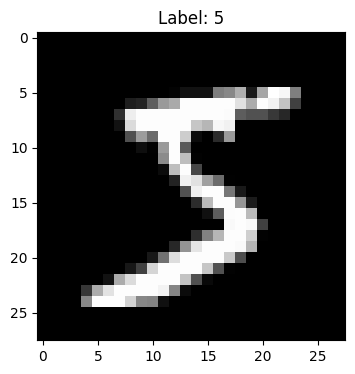

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Call the function to get the data
# Note: I've corrected some bugs in the original file parsing logic (magic numbers)
# to ensure it runs correctly. The function below is the corrected version.

def get_mnist_corrected():
    import gzip, os, struct
    from urllib.request import urlretrieve
    
    def parse_data(src_url, num_samples, is_labels=False):
        print(f"Downloading and parsing {src_url}")
        gzfname, _ = urlretrieve(src_url, "./delete.me")
        try:
            with gzip.open(gzfname, 'rb') as gz:
                magic_number = struct.unpack('>I', gz.read(4))[0]
                expected_magic = 2049 if is_labels else 2051
                if magic_number != expected_magic:
                    raise ValueError(f"Invalid magic number {magic_number}, expected {expected_magic}")
                
                num_items = struct.unpack('>I', gz.read(4))[0]
                if num_items != num_samples:
                    raise ValueError(f"Expected {num_samples} items, file contains {num_items}")

                if is_labels:
                    data = np.frombuffer(gz.read(), dtype=np.uint8)
                else:
                    num_rows = struct.unpack('>I', gz.read(4))[0]
                    num_cols = struct.unpack('>I', gz.read(4))[0]
                    if num_rows != 28 or num_cols != 28:
                        raise ValueError("Images are not 28x28")
                    data = np.frombuffer(gz.read(), dtype=np.uint8).reshape(num_samples, 28, 28)
        finally:
            os.remove(gzfname)
        return data

    server = 'https://raw.githubusercontent.com/fgnt/mnist/master'
    train_count, test_count = 60000, 10000
    
    x_train = parse_data(f'{server}/train-images-idx3-ubyte.gz', train_count) / 255.0
    y_train = parse_data(f'{server}/train-labels-idx1-ubyte.gz', train_count, is_labels=True)
    x_test = parse_data(f'{server}/t10k-images-idx3-ubyte.gz', test_count) / 255.0
    y_test = parse_data(f'{server}/t10k-labels-idx1-ubyte.gz', test_count, is_labels=True)
    
    return x_train, y_train, x_test, y_test

# Execute the corrected function
x_train, y_train, x_test, y_test = get_mnist_corrected()

# Print the shapes to verify
print("\n✅ Data loaded successfully!")
print(f"Training images shape: {x_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Testing images shape: {x_test.shape}")
print(f"Testing labels shape: {y_test.shape}")

# Visualize a sample
plt.figure(figsize=(4, 4))
plt.imshow(x_train[0], cmap='gray')
plt.title(f"Label: {y_train[0]}")
plt.grid(False)
plt.show()

## 2. Prepare Data and Build the Classifier

Now that we have the data, we'll prepare it for our model and build a simple **multiclass logistic regression** classifier, just as we did before.

1.  **Flatten Images**: Reshape each 28x28 image into a single 784-element vector.
2.  **Initialize Parameters**: Create the weight `W` and bias `b` matrices with random values.
3.  **Train the Model**: Use a training loop to adjust the weights and biases to minimize the error (loss).

In [11]:
# --- 1. Prepare the Data ---
# Flatten the images from 28x28 to 784. Normalization was already done.
x_train_flat = x_train.reshape(x_train.shape[0], -1)
x_test_flat = x_test.reshape(x_test.shape[0], -1)
print(f"Shape of flattened training data: {x_train_flat.shape}")

# --- 2. Build and Train the Classifier ---
def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

# Initialize Weights and Biases
num_features, num_classes = 784, 10
W = np.random.randn(num_features, num_classes) * 0.01
b = np.zeros((1, num_classes))

# Training Settings
learning_rate = 0.1
iterations = 1000
y_train_one_hot = np.eye(num_classes)[y_train]

# Training Loop
for i in range(iterations):
    # Forward Pass
    scores = x_train_flat @ W + b
    probabilities = softmax(scores)
    
    # Loss Calculation
    loss = -np.mean(np.sum(y_train_one_hot * np.log(probabilities + 1e-9), axis=1))
    if i % 100 == 0:
        print(f"Iteration {i}, Loss: {loss:.4f}")
        
    # Backward Pass (Gradient Calculation)
    d_scores = probabilities - y_train_one_hot
    dW = (x_train_flat.T @ d_scores) / x_train_flat.shape[0]
    db = np.sum(d_scores, axis=0, keepdims=True) / x_train_flat.shape[0]
    
    # Update Parameters
    W -= learning_rate * dW
    b -= learning_rate * db

print("\n✅ Training complete!")

Shape of flattened training data: (60000, 784)
Iteration 0, Loss: 2.3009
Iteration 100, Loss: 0.6096
Iteration 200, Loss: 0.4898
Iteration 300, Loss: 0.4406
Iteration 400, Loss: 0.4123
Iteration 500, Loss: 0.3933
Iteration 600, Loss: 0.3795
Iteration 700, Loss: 0.3688
Iteration 800, Loss: 0.3602
Iteration 900, Loss: 0.3530

✅ Training complete!


## 3. Evaluate the Model

Finally, we'll use the trained weights and biases to make predictions on the **test data** and calculate the final accuracy of our model.

In [ ]:
# Make predictions on the test set
test_scores = x_test_flat @ W + b
test_probabilities = softmax(test_scores)
predictions = np.argmax(test_probabilities, axis=1)

# Calculate accuracy
accuracy = np.mean(predictions == y_test) * 100
print(f"Model Accuracy on Test Data: {accuracy:.2f}%")

# Visualize some predictions
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
axes = axes.ravel()
for i in range(10):
    axes[i].imshow(x_test[i], cmap='gray')
    axes[i].set_title(f"True: {y_test[i]}\nPred: {predictions[i]}")
    axes[i].axis('off')
plt.suptitle("Sample Test Predictions")
plt.show()